<a href="https://colab.research.google.com/github/jerahmeelmitchao/AgriScan/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check the tensorflow version

import tensorflow as tf
tf.__version__

import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch.transforms import ToTensorV2



from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

DATASET_PATH = "/content/drive/MyDrive/RiceLeafDisease"
os.listdir(DATASET_PATH)

['SheathBlight', 'Tungro', 'BacterialBlight']

In [6]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [7]:
import os, random

MAX_IMAGES = 400

# Load file lists
bacterial_list = os.listdir(f"{DATASET_PATH}/BacterialBlight")
sheath_list    = os.listdir(f"{DATASET_PATH}/SheathBlight")
tungro_list    = os.listdir(f"{DATASET_PATH}/Tungro")

# Shuffle to avoid bias
random.shuffle(bacterial_list)
random.shuffle(sheath_list)
random.shuffle(tungro_list)

# Limit to 400 images each
bacterial_list = bacterial_list[:MAX_IMAGES]
sheath_list    = sheath_list[:MAX_IMAGES]
tungro_list    = tungro_list[:MAX_IMAGES]

print("Bacterial Blight:", len(bacterial_list))
print("Sheath Blight:", len(sheath_list))
print("Tungro:", len(tungro_list))


Bacterial Blight: 400
Sheath Blight: 400
Tungro: 400


In [47]:
from sklearn.model_selection import train_test_split

# Bacterial Blight
df_bacterial_blight_train, df_bacterial_blight_val = train_test_split(
    df_bacterial_blight, test_size=0.2, random_state=101
)

# Sheath Blight
df_sheath_blight_train, df_sheath_blight_val = train_test_split(
    df_sheath_blight, test_size=0.2, random_state=101
)

# Tungro
df_tungro_train, df_tungro_val = train_test_split(
    df_tungro, test_size=0.2, random_state=101
)

print("Bacterial Blight val:", len(df_bacterial_blight_val))
print("Sheath Blight val:", len(df_sheath_blight_val))
print("Tungro val:", len(df_tungro_val))



Bacterial Blight val: 80
Sheath Blight val: 80
Tungro val: 80


In [49]:
# Create the train set for each class

# bacterial_blight
# get a list of val images
val_list = list(df_bacterial_blight_val['image'])
# filter out the val images
df_bacterial_blight_train = df_bacterial_blight[~df_bacterial_blight['image'].isin(val_list)]


# sheath_blight
# get a list of val images
val_list = list(df_sheath_blight_val['image'])
# filter out the val images
df_sheath_blight_train = df_sheath_blight[~df_sheath_blight['image'].isin(val_list)]


# tungro
# get a list of val images
val_list = list(df_tungro_val['image'])
# filter out the val images
df_tungro_train = df_tungro[~df_tungro['image'].isin(val_list)]


print(len(df_bacterial_blight_train))
print(len(df_sheath_blight_train))
print(len(df_tungro_train))


320
320
320


In [50]:
# Combine full dataset
df_data = pd.concat(
    [df_bacterial_blight, df_sheath_blight, df_tungro],
    axis=0
).reset_index(drop=True)


# Combine training set
df_train = pd.concat(
    [df_bacterial_blight_train, df_sheath_blight_train, df_tungro_train],
    axis=0
).reset_index(drop=True)


# Combine validation set
df_val = pd.concat(
    [df_bacterial_blight_val, df_sheath_blight_val, df_tungro_val],
    axis=0
).reset_index(drop=True)


# Shuffle datasets
df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)


(1200, 2)
(960, 2)
(240, 2)


In [51]:
df_data['target'].value_counts()

,count
target,
bacterial_blight,400
sheath_blight,400
tungro,400


In [52]:
df_train['target'].value_counts()

,count
target,
bacterial_blight,320
sheath_blight,320
tungro,320


In [53]:
df_val['target'].value_counts()

,count
target,
tungro,80
bacterial_blight,80
sheath_blight,80


In [54]:
# Create the target as index values

# combine val, train and test
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(960, 4)
(240, 4)


In [15]:
df_combined.head()

,image,target_bacterial_blight,target_sheath_blight,target_tungro
0,aug_0_9156.jpg,False,True,False
1,BACTERAILBLIGHT3_043.jpg,True,False,False
2,BACTERAILBLIGHT3_097.jpg,True,False,False
3,TUNGRO4_242.JPG,False,False,True
4,BACTERAILBLIGHT4_004.jpg,True,False,False


In [16]:
df_train.head()

,image,target_bacterial_blight,target_sheath_blight,target_tungro
15,TUNGRO1_088.jpg,False,False,True
16,aug_0_9038.jpg,False,True,False
17,aug_0_8524.jpg,False,True,False
18,BACTERAILBLIGHT5_155.jpg,True,False,False
19,IMG_20231014_173954.jpg,False,True,False


In [17]:
df_val.head()

,image,target_bacterial_blight,target_sheath_blight,target_tungro
0,aug_0_9156.jpg,False,True,False
1,BACTERAILBLIGHT3_043.jpg,True,False,False
2,BACTERAILBLIGHT3_097.jpg,True,False,False
3,TUNGRO4_242.JPG,False,False,True
4,BACTERAILBLIGHT4_004.jpg,True,False,False


In [18]:

df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

In [19]:
!ls

df_combined.csv.gz  df_train.csv.gz  df_val.csv.gz  drive  sample_data


In [20]:
# Create a new directory
image_dir = 'image_dir'
os.mkdir(image_dir)

!ls

df_combined.csv.gz  df_val.csv.gz  image_dir
df_train.csv.gz     drive	   sample_data


In [21]:
# Use existing image lists from Google Drive
leaf_smut_list = bacterial_list
brown_spot_list = sheath_list
bacterial_leaf_blight_list = tungro_list


# Transfer Bacterial Blight images
for fname in leaf_smut_list:

    path = f"{DATASET_PATH}/BacterialBlight/"

    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)

    shutil.copyfile(src, dst)



# Transfer Sheath Blight images
for fname in brown_spot_list:

    path = f"{DATASET_PATH}/SheathBlight/"

    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)

    shutil.copyfile(src, dst)



# Transfer Tungro images
for fname in bacterial_leaf_blight_list:

    path = f"{DATASET_PATH}/Tungro/"

    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)

    shutil.copyfile(src, dst)


In [22]:
# Check how many images are now in image_dir

len(os.listdir('image_dir'))

1200

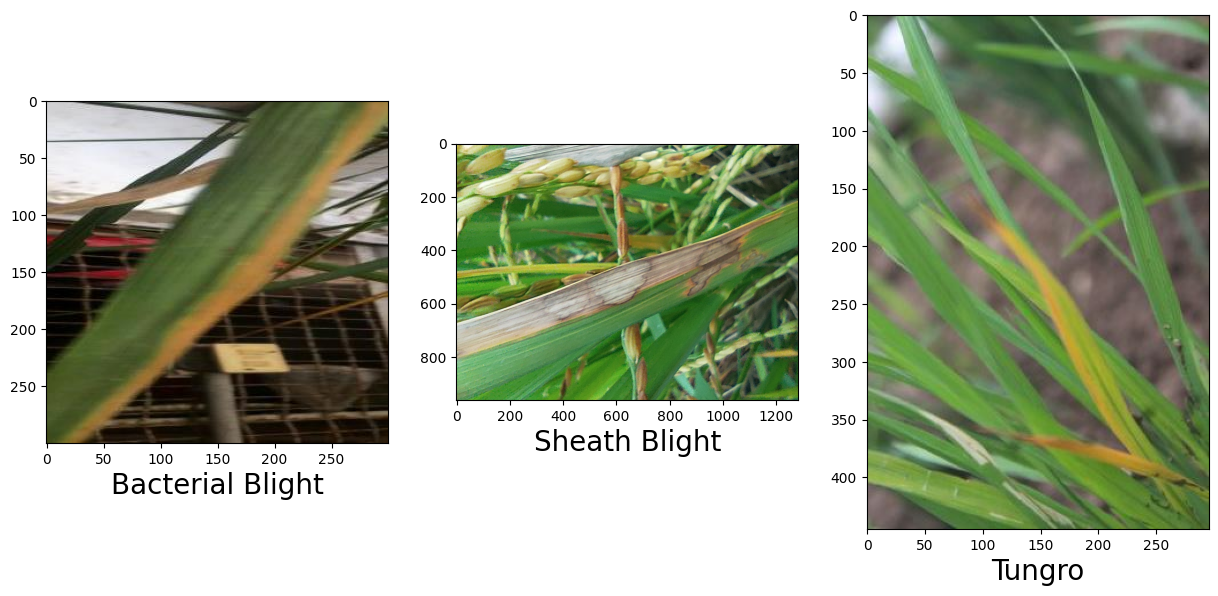

In [23]:
# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1 — Bacterial Blight
plt.subplot(1,3,1)
item = leaf_smut_list[0]
path = f"{DATASET_PATH}/BacterialBlight/{item}"
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial Blight', fontsize=20)


# Image 2 — Sheath Blight
plt.subplot(1,3,2)
item = brown_spot_list[0]
path = f"{DATASET_PATH}/SheathBlight/{item}"
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Sheath Blight', fontsize=20)


# Image 3 — Tungro
plt.subplot(1,3,3)
item = bacterial_leaf_blight_list[0]
path = f"{DATASET_PATH}/Tungro/{item}"
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Tungro', fontsize=20)

plt.show()


In [24]:
# Albumentations

import albumentations as albu


def augment_image(augmentation, image):

    """
    Uses the Albumentations library.

    Inputs:
    1. augmentation - this is the instance of type of augmentation to do
    e.g. aug_type = HorizontalFlip(p=1)
    # p=1 is the probability of the transform being executed.

    2. image - image with shape (h,w)

    Output:
    Augmented image as a numpy array.

    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']


    return image_matrix

In [25]:
# Define the transforms


aug_types = albu.Compose([

    albu.HorizontalFlip(),

    albu.OneOf([
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
    ], p=0.8),

    albu.OneOf([
        albu.RandomBrightnessContrast(),
        albu.HueSaturationValue(),
    ], p=0.3),

    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=6),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2),
    ], p=0.3),

    albu.Affine(scale=(0.9, 1.1), rotate=(-15, 15))

])



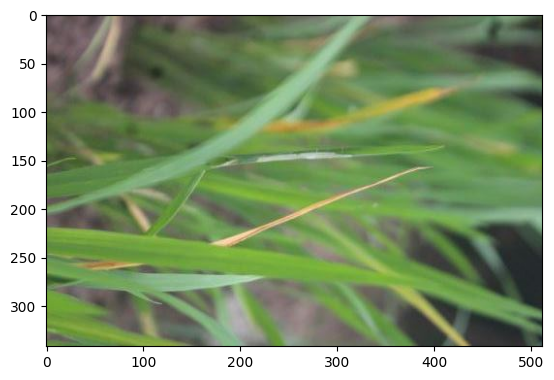

In [26]:
# Get an image to test transformations

# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

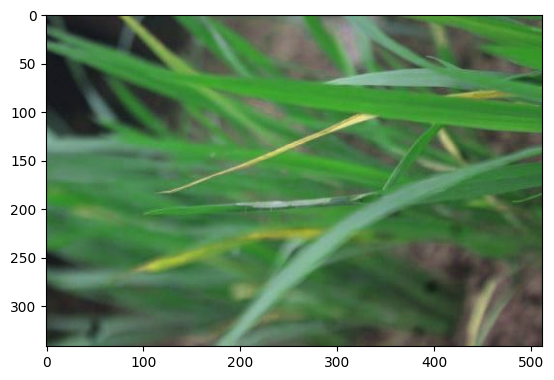

In [27]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

Build Data Generator


In [28]:
df_train.head()

,image,target_bacterial_blight,target_sheath_blight,target_tungro
15,TUNGRO1_088.jpg,False,False,True
16,aug_0_9038.jpg,False,True,False
17,aug_0_8524.jpg,False,True,False
18,BACTERAILBLIGHT5_155.jpg,True,False,False
19,IMG_20231014_173954.jpg,False,True,False


In [29]:
def train_generator(batch_size=8):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):

            image_id_list = list(df['image'])

            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS),
                               dtype=np.uint8)

            # 🔹 CORRECT CLASS LABEL COLUMNS
            cols = [
                'target_bacterial_blight',
                'target_sheath_blight',
                'target_tungro'
            ]
            y_train = np.asarray(df[cols])


            # build X_train
            for i in range(0, len(image_id_list)):

                image_id = image_id_list[i]
                path = 'image_dir/' + image_id

                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                aug_image = augment_image(aug_types, image)

                X_train[i] = aug_image


            # normalize images
            X_train = X_train / 255.0

            yield X_train, y_train


In [30]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [31]:
y_train

array([[False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False]])

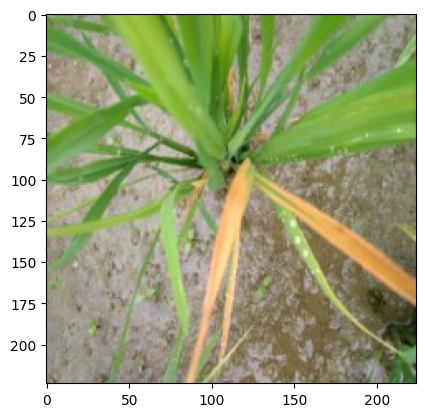

In [32]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

Val Generator


In [33]:
def val_generator(batch_size=5):

    while True:

        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            image_id_list = list(df['image'])

            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS),
                             dtype=np.uint8)

            # 🔹 CORRECT CLASS LABEL COLUMNS
            cols = [
                'target_bacterial_blight',
                'target_sheath_blight',
                'target_tungro'
            ]
            y_val = np.asarray(df[cols])


            # build X_val
            for i in range(0, len(image_id_list)):

                image_id = image_id_list[i]
                path = 'image_dir/' + image_id

                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                X_val[i] = image


            X_val = X_val / 255.0

            yield X_val, y_val


In [34]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)
# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


In [35]:
y_val

array([[False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False]])

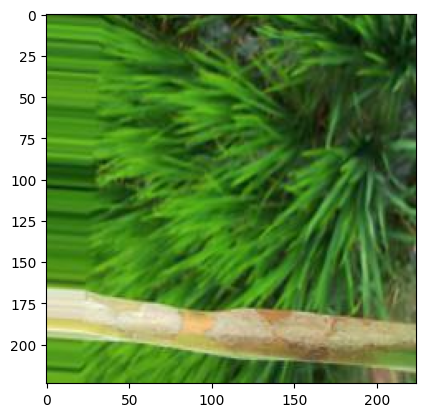

In [36]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

Test Generator

In [37]:
def test_generator(batch_size=1):

    while True:

        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            image_id_list = list(df['image'])

            X_test = np.zeros(
                (len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS),
                dtype=np.uint8
            )

            for i in range(len(image_id_list)):

                image_id = image_id_list[i]
                path = 'image_dir/' + image_id

                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                X_test[i] = image

            X_test = X_test / 255.0

            yield X_test


In [38]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


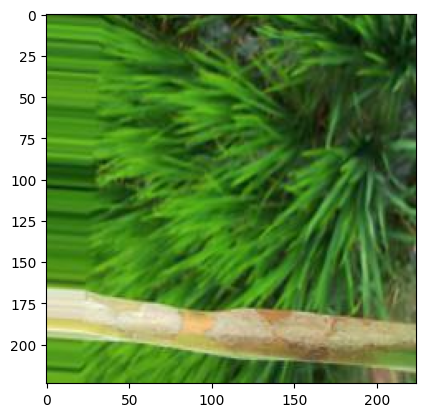

In [39]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)

Model Architecture

In [40]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)

In [41]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,256,867 (16.24 MB)

 Trainable params: 4,234,979 (16.16 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [42]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [44]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen   = val_generator(batch_size=VAL_BATCH_SIZE)

# Ensure step values are integers
train_steps = len(df_train) // TRAIN_BATCH_SIZE
val_steps   = len(df_val)   // VAL_BATCH_SIZE

print("Train steps:", train_steps)
print("Val steps:", val_steps)


# ====== OPTIMIZER (BETTER SETTINGS) ======
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(
        learning_rate=1e-4,       # good for fine-tuning
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# ====== CHECKPOINT (BEST MODEL) ======
filepath = "model_best.h5"

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)


# ====== EARLY STOPPING (PREVENT OVERFITTING) ======
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=8,              # stop if no improvement
    restore_best_weights=True,
    verbose=1
)


# ====== LEARNING RATE SCHEDULER ======
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,              # reduce LR when stuck
    patience=4,
    min_lr=1e-6,
    verbose=1
)


# ====== TRAIN LOGGING ======
log_fname = 'training_log.csv'

csv_logger = CSVLogger(
    filename=log_fname,
    separator=',',
    append=False
)


# ====== FINAL CALLBACK LIST ======
callbacks_list = [checkpoint, earlystop, reduce_lr, csv_logger]


# ====== START TRAINING ======
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=100,                 # allow long training
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=callbacks_list,
    verbose=1
)


Train steps: 148
Val steps: 3
Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7270 - loss: 1.0691
Epoch 1: val_accuracy improved from -inf to 0.93333, saving model to model_best.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 45s 131ms/step - accuracy: 0.7277 - loss: 1.0662 - val_accuracy: 0.9333 - val_loss: 0.9759 - learning_rate: 1.0000e-04
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9118 - loss: 0.3142
Epoch 2: val_accuracy improved from 0.93333 to 1.00000, saving model to model_best.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9120 - loss: 0.3139 - val_accuracy: 1.0000 - val_loss: 0.0068 - learning_rate: 1.0000e-04
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9316 - loss: 0.2824
Epoch 3: val_accuracy did not improve from 1.00000
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.9316 - loss: 0.2820 - val_accuracy: 0.9333 - val_loss: 0.2016 - learning_rate: 1.0000e-04
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9667 - loss: 0.1367
Epoch 4: val_accuracy did not improve from 1.00000
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9668 - loss: 0.1365 - val_accuracy: 1.0000 - val_loss: 2.2980e-05 - learning_rate: 1.0000e-04
Epoch 5/100
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9540 - loss: 0.1692
Epoch 5: val_accuracy did not improve from 1.00000
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9541 - loss: 0.1689 - val_accuracy: 1.0000 - val_loss: 9.6162e-07 - learning_rate: